In [1]:
import pandas as pd 
import networkx as nx 
from tqdm import tqdm 
tqdm.pandas()
import matplotlib.pyplot as plt
from statistics import mean
from tqdm import tqdm 
import numpy as np 
from datetime import datetime 
import csv 
import tikzplotlib
from utils_graph import *

In [2]:
type='undirected'
GC = build_graph_from_csv('../data/cpnet47rel/conceptnet.en.csv', type)
GS = build_graph_from_csv('../data/swow.en.csv', type)

In [11]:

def find_shortest_path(S, T):
    '''
    function: for each edge in a sourge graph S, find its shortest path in T

    plens: a list with each element as the path lengths of connecting each edge 
    edge_recall: a float number, indicating the number of edges being recalled in the target graph T 
    '''
    plens = []
    shortest_paths = []
    for (u,v, rel) in S.edges.data(data=True):
        if u in T.nodes and v in T.nodes and nx.algorithms.shortest_paths.generic.has_path(T, u, v):
            plen = nx.shortest_path_length(T, u, v)
            plens.append(plen)
            paths = nx.all_shortest_paths(T, u, v)
            shortest_paths.append(paths) 
    edge_recall = len(plens)/S.size()            
    return plens, edge_recall , shortest_paths

def subgraph_info(triples, normalize_size=True):
    if len(triples) == 0:
        avg_deg, avg_density= 0, 0   

    G = build_graph_from_triples(triples, type)
    plen1, edge_recall1, shortest_paths_1 = find_shortest_path(G, GC)
    plen2, edge_recall2, shortest_paths_2 = find_shortest_path(G, GS)
    if len(plen1)==0:
        print("plen1 not exist")
        mean_plen1 = 1e6 
    else:
        mean_plen1 = mean(plen1)

    if len(plen2)==0:
         print("plen2 not exist")
         mean_plen2 = 1e6 
    else:
        mean_plen2 = mean(plen2)

    return pd.Series([mean_plen1, mean_plen2, edge_recall1, edge_recall2, shortest_paths_1, shortest_paths_2 ])


In [12]:
def main(path, output_path=None):
    '''
    a) read a csv file and b)build a graph for each triples in each row; c) get graph info of individual graphs; d) get the average info over all graphs
    '''
    df = read_scripts_triples(path)
    # df = df.iloc[686]

    df[['mean_path_len_cn','mean_path_len_sw', 'edge_recall_cn', 'edge_recall_sw', 'shortest_paths_cn', 'shortest_paths_sw']] = df['triple_lemma'].progress_apply(lambda x: subgraph_info(eval(x)))
    
    if output_path is not None:
        df.to_csv(output_path)
    print(f'save {output_path} {len(df.index)} lines')

    return df 

In [13]:
# path = '../output/mcscript2.csv_frame_lemma.csv'
path = '../output/mcscript2.csv_frame.csv'
output_path = '../output/mcscript2.csv_graph_shortest_path.csv'
# df = main(path, output_path)
df = main(path, output_path=None)

  0%|          | 0/3487 [00:00<?, ?it/s]


removing invalid scripts 0 
 remaining 3487 scripts


  0%|          | 11/3487 [19:10<109:34:49, 113.49s/it]

In [10]:
dfq = df.query("mean_path_len_cn!=1e6 and mean_path_len_sw!=1e6")

# The saved path will be used in latex to draw a hist grapm using tikz
# output_path1 = "../output/shortest_path_cn.csv"
# output_path2 = "../output/shortest_path_sw.csv"

# dfq['mean_path_len_cn'].to_csv(output_path1, index=False, header=False)
# dfq['mean_path_len_sw'].to_csv(output_path2, index=False, header=False)

# print(f"save {output_path1}")
# print(f"save {output_path2}")

In [ ]:
df.head()

## plot the distribution of mean shorest path len (CN, SW)

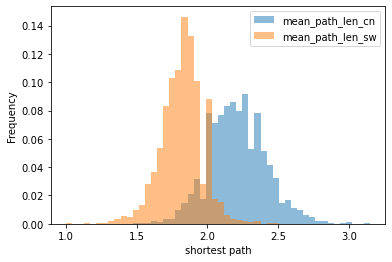

In [8]:
dfq = df 
N = len(dfq.index)
fig, ax = plt.subplots()
dfq[['mean_path_len_cn', 'mean_path_len_sw']].describe()
# dfq[['mean_path_len_cn', 'mean_path_len_sw']].hist(ax=ax,)

dfq[['mean_path_len_cn', 'mean_path_len_sw']].plot(ax=ax, kind="hist", alpha=0.5, bins=50, weights=np.ones(N) / N)
ax.set_xlabel("shortest path")
# dfq[['edge_recall_cn', 'edge_recall_sw']].plot(kind="hist", alpha=0.5, bins=50)
plt.show()
fig = ax.get_figure()
# fig.savefig('/path/to/figure.pdf')

output_path = '../log/mean_shortest_path.csv'
dfq[['mean_path_len_cn', 'mean_path_len_sw']].to_csv(output_path)


In [17]:
# case study1: why peak at 2 

df2 = df.query("mean_path_len_cn==2.0 and mean_path_len_sw==1.6")
print(list(df2.id.values))



[269, 867, 1282, 1514]


In [149]:
plt.style.use("ggplot") 
import matplotlib.ticker as ticker
x = dfq['mean_path_len_sw']
data_path = '../log/path_hist.csv'
x.round(4).to_csv(data_path, index=False)


## Plot the edge recall of each KG

,edge_recall_cn,edge_recall_sw
count,3487.000000,3487.000000
mean,0.731535,0.727472
std,0.146420,0.147332
min,0.176471,0.176471
25%,0.636364,0.631579
50%,0.739130,0.736842
75%,0.838710,0.833333
max,1.000000,1.000000


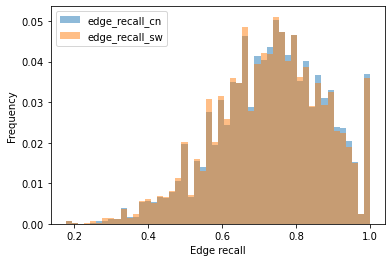

save ../output/shortest_path_recall_cn.dat
save ../output/shortest_path_recall_cn.dat


In [28]:

dfq = df 
N = len(dfq.index)
fig, ax = plt.subplots()
display(dfq[['edge_recall_cn', 'edge_recall_sw']].describe())
dfq[['edge_recall_cn', 'edge_recall_sw']].plot(ax=ax, kind="hist", alpha=0.5, bins=50, weights=np.ones(N) / N)
ax.set_xlabel("Edge recall")
plt.show()
fig = ax.get_figure()

## The saved path will be used in latex to draw a hist grapm using tikz
output_path_cn = "../output/shortest_path_recall_cn.dat"
output_path_sw = "../output/shortest_path_recall_sw.dat"

dfq['edge_recall_cn'].to_csv(output_path_cn, index=False, header=False, sep=' ')
dfq['edge_recall_sw'].to_csv(output_path_sw, index=False, header=False, sep=' ')


print(f"save {output_path_cn}")
print(f"save {output_path_cn}")

save ../log/path_distribution.pdf
[(0.0008605851979345954, 1.0), (0.0, 1.0333333333333334), (0.0, 1.0666666666666667), (0.0005737234652897303, 1.1), (0.00028686173264486515, 1.1333333333333333), (0.0, 1.1666666666666667), (0.0005737234652897303, 1.2), (0.0008605851979345954, 1.2333333333333334), (0.00028686173264486515, 1.2666666666666666), (0.0008605851979345954, 1.3), (0.005163511187607573, 1.3333333333333333), (0.001721170395869191, 1.3666666666666667), (0.007171543316121629, 1.4), (0.004302925989672977, 1.4333333333333333), (0.0008605851979345954, 1.4666666666666668), (0.020654044750430253, 1.5), (0.016637980493402153, 1.5333333333333332), (0.018072289156626474, 1.5666666666666667), (0.04274239816408494, 1.6), (0.021514629948364845, 1.6333333333333333), (0.07659208261617899, 1.6666666666666665), (0.07802639127940329, 1.7), (0.09036144578313231, 1.7333333333333334), (0.07200229489386122, 1.7666666666666666), (0.13425129087779603, 1.8), (0.06942053930005747, 1.8333333333333335), (0.0

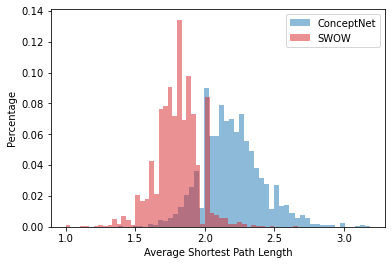

In [23]:
x  = dfq
N = len(x.index)

fig, ax = plt.subplots(figsize=(6, 4))

ax.set_facecolor("white")

# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))

num_of_bins=50
xvals, yvals,_ = ax.hist(x[ 'mean_path_len_cn'], density=False, bins=num_of_bins, facecolor='tab:blue', alpha=0.5, weights=np.ones(N) / N)

xvals, yvals,_ = ax.hist(x[ 'mean_path_len_sw'], density=False, bins=num_of_bins, facecolor='tab:red', alpha=0.5, weights=np.ones(N) / N)


# ax.hist(x['mean_path_len_sw'], density=False, bins=num_of_bins, facecolor='tab:red', alpha=0.5,weights=np.ones(N) / N)


plt.xlabel('Average Shortest Path Length')
plt.ylabel('Percentage')
plt.legend(["ConceptNet", "SWOW"], loc ="best")

tikz_path = '../log/path_distribution.tex'
fig_path = '../log/path_distribution.pdf'

tikzplotlib.save(tikz_path)
plt.savefig(fig_path)
print(f"save {fig_path}")


#
print([(i,j) for i,j in zip(xvals,yvals)])
# plt.bar(xvals, yvals)
plt.show()


## Case study: long vs short paths in CN and SWOW

In [6]:
df

,id,scenario,text,sent,frame,triple,triple_lemma,triple_num,mean_path_len_cn,mean_path_len_sw,edge_recall_cn,edge_recall_sw
0,0,renovating a room,"last week , my girlfriend and i decided to ren...","['last week , my girlfriend and i decided to r...","{('ARG0V', 'we', 'needed'), ('ARG1V', 'at the ...","{('ARG1V', 'pictures', 'looking'), ('ARG1V', '...","{('ARG1V', 'store', 'need'), ('ARG1V', 'make',...",34,2.137931,1.931034,0.852941,0.852941
1,1,drying clothes,the sharp buzz of the washing machine timer di...,['the sharp buzz of the washing machine timer ...,"{('ARG01', 'i', 'the comforting hum of the dry...","{('ARG1V', 'comforting hum', 'heard'), ('ARG0V...","{('ARG1V', 'clothe', 'grab'), ('ARG1V', 'washe...",17,2.500000,2.100000,0.588235,0.588235
2,2,serving a drink,i am at work . i have a guest sit at the bar ....,"['i am at work .', 'i have a guest sit at the ...","{('ARG01', 'i', 'a nice cold mug'), ('ARG1V', ...","{('ARG1V', 'guest', 'sit'), ('ARG1V', 'cash', ...","{('ARG1V', 'guest', 'sit'), ('ARG1V', 'beer', ...",12,1.900000,2.000000,0.833333,0.833333
3,3,taking a photograph,i wanted to take a photograph of something nat...,['i wanted to take a photograph of something n...,"{('ARG1V', 'everything that i wanted to come o...","{('ARG1V', 'save', 'made'), ('ARG1V', 'green t...","{('ARG1V', 'whole tree', 'come'), ('ARG1V', 's...",26,1.900000,1.750000,0.800000,0.800000
4,4,looking for a flat,"after i finished university , i wanted to move...","['after i finished university , i wanted to mo...","{('ARG0V', 'i', 'dating'), ('ARG1V', 'like doi...","{('ARG1V', 'couch', 'wanted'), ('ARG1V', 'day'...","{('ARG1V', 'university', 'finish'), ('ARG1V', ...",20,1.950000,1.650000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3482,2495,making a bonfire,"it 's summertime , and my favorite thing to do...","[""it 's summertime , and my favorite thing to ...","{('ARG01', 'for the larger limbs to start to c...","{('ARG1V', 'fire', 'catch'), ('ARG1V', 'wood',...","{('ARG1V', 'wood', 'gather'), ('ARG1V', 'fire'...",78,2.312500,1.958333,0.615385,0.615385
3483,2496,washing dishes,"the last time that i washed dishes , i first r...","['the last time that i washed dishes , i first...","{('ARG1V', 'it', 'put'), ('ARG1V', 'them', 'cl...","{('ARG1V', 'one', 'drying'), ('ARG1V', 'puttin...","{('ARG1V', 'dish', 'wash'), ('ARG1V', 'sponge'...",5,1.800000,1.600000,1.000000,1.000000
3484,2497,taking medicine,to take medicine first you have to have medici...,['to take medicine first you have to have medi...,"{('ARG1V', 'medicine', 'have'), ('ARG01', 'i',...","{('ARG0V', 'cooling liquid', 'helping'), ('ARG...","{('ARG1V', 'multiple option', 'debate'), ('ARG...",20,2.250000,1.875000,0.800000,0.800000
3485,2498,checking in at an airport,"my flight was on time to germany , but driving...","['my flight was on time to germany , but drivi...","{('ARG01', 'i', 'to get on time i still had to...","{('ARG1V', 'lots', 'saved'), ('ARG1V', 'space'...","{('ARG1V', 'bag', 'hope'), ('ARG1V', 'inn', 'r...",21,2.200000,1.900000,0.952381,0.952381


save ../log/path_distribution.pdf


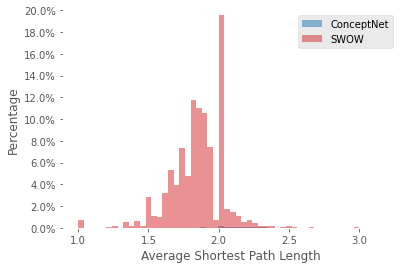

In [111]:

# plt.style.use("ggplot") 
import matplotlib.ticker as ticker
N = len(x.index)
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax))


fig, ax = plt.subplots()
ax.set_facecolor("white")
# axs.set_axis_bgcolor('white')

# We can set the number of bins with the `bins` kwarg
# axs.hist(x['mean_path_len_cn'], 50, density=False, facecolor='tab:blue', alpha=0.5)
# axs.hist(x['mean_path_len_sw'], 50, density=False, facecolor='tab:red', alpha=0.5)

# ax.hist(x['mean_path_len_cn'], 50, facecolor='tab:blue', alpha=0.5)
# ax.hist(x['mean_path_len_sw'], 50, facecolor='tab:red', alpha=0.5 )
# ax.grid(True)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))
num_of_bins=50
y_vals, x_vals, e_ = ax.hist(x['mean_path_len_cn'], density=1, bins=num_of_bins, facecolor='tab:blue', alpha=0.5)

y_vals, x_vals, e_ = ax.hist(x['mean_path_len_sw'], bins=num_of_bins, facecolor='tab:red', alpha=0.5)

y_max = round((max(y_vals) / len(x.index)) + 0.01, 2)
ax.set_yticks(ticks=np.arange(0.0, y_max * N, 0.02 * N))
ax.set_ylim(ax.get_yticks()[0], ax.get_yticks()[-1])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=N))


plt.xlabel('Average Shortest Path Length')
plt.ylabel('Percentage')
plt.legend(["ConceptNet", "SWOW"], loc ="best")

# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.xlim(40, 160)
# plt.ylim(0, 0.03)
# plt.grid(False)
# plt.show()
# import matplotlib2tikz
# matplotlib2tikz.save("test.tex")

tikz_path = '../log/path_distribution.tex'
fig_path = '../log/path_distribution.pdf'

tikzplotlib.save(fig_path)
plt.savefig(fig_path)
print(f"save {fig_path}")


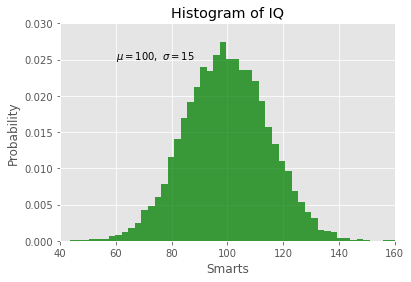

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(40, 160)
plt.ylim(0, 0.03)
plt.grid(True)
plt.show()